# <center>Développement d'un modèle de détection de Plantes <br> (Maïs, Piment, Tomate) <br> et leurs maladies respectives.</center>

<div style="display: flex; justify-content: center;">
    <div style="margin: 10px;">
        <img src="dataset/Mais/Sain/00031d74-076e-4aef-b040-e068cd3576eb___R.S_HL%208315%20copy%202.jpg" alt="Image de Maïs" style="width: 200px; height: auto; border-radius: 10px;">
    </div>
    <div style="margin: 10px;">
        <img src="dataset/Piment/Sain/00100ffa-095e-4881-aebf-61fe5af7226e___JR_HL%207886.JPG" alt="Image de Piment" style="width: 200px; height: auto; border-radius: 10px;">
    </div>
    <div style="margin: 10px;">
        <img src="dataset/Tomate/Sain/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL%20Leaf%20259.1.JPG" alt="Image de Tomate" style="width: 200px; height: auto; border-radius: 10px;">
    </div>
</div>

<p style="text-align: center;">Ce dataset a été fourni par <Strong style="color: #2980B9;">Warisse OTCHADE</Strong> dans le cadre de sa soutenance de licence</p>

### Étape 1: Importer les bibliothèques nécessaires

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

### Étape 2 : Préparation des Données

In [4]:
# Chemin du dataset
data_dir = 'dataset/'

# Préparation du générateur d'images avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisation des pixels
    shear_range=0.2,             # Déformation des images
    zoom_range=0.2,              # Zoom aléatoire
    horizontal_flip=True,        # Flip horizontal
    validation_split=0.2)        # 20% des données pour la validation

# Générateur de données pour l'entraînement
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),       # Redimensionner les images à 224x224 (standard pour ResNet)
    batch_size=32,
    class_mode='categorical',     # Mode pour la classification multiclass
    subset='training')

# Générateur de données pour la validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 19590 images belonging to 3 classes.
Found 4897 images belonging to 3 classes.


### Étape 3 : Construction du Modèle
Nous allons utiliser ResNet50 (ou tout autre modèle de type CNN préentraîné). L’idée est de fine-tuner ce modèle en ajoutant des couches pour l’adapter à notre classification des maladies des plantes.

In [ ]:
#local_weights_path = 'modelPreEntraine/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# Chemin pour sauvegarder les poids localement (ajoute .weights.h5 à la fin)
local_weights_path = 'modelPreEntraine/resnet50_weights_tf_dim_ordering_tf_kernels_notop.weights.h5'

# Vérifier si les poids existent déjà
if os.path.exists(local_weights_path):
    # Charger le modèle avec les poids locaux
    model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
    model.load_weights(local_weights_path)
else:
    # Télécharger les poids et les sauvegarder localement
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Sauvegarder les poids localement avec l'extension correcte
    model.save_weights(local_weights_path)

In [19]:
# Charger le modèle pré-entraîné ResNet50 sans la dernière couche
local_weights_path = 'modelPreEntraine/resnet50_weights_tf_dim_ordering_tf_kernels_notop.weights.h5'
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights(local_weights_path)

# Geler les couches du modèle de base pour éviter de réentraîner les poids
base_model.trainable = False

# Créer le modèle final
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Remplacer Flatten par un pooling global
    Dense(256, activation='relu'),  # Ajouter une couche dense
    Dense(train_generator.num_classes, activation='softmax')  # Sortie avec autant de classes que de maladies
])

# Compiler le modèle avec Adam comme optimiseur
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Étape 4 : Entraînement du Modèle
Nous allons entraîner le modèle avec les données d’entraînement et valider ses performances sur les données de validation.

In [21]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20)  # Ajuster en fonction des ressources disponibles

Epoch 1/20


e:\Programmation_Python\FaceRecognitionProject\.venv\FaceEnv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


612/612 ━━━━━━━━━━━━━━━━━━━━ 2922s 5s/step - accuracy: 0.7106 - loss: 0.7698 - val_accuracy: 0.7400 - val_loss: 0.6753
Epoch 2/20
  1/612 ━━━━━━━━━━━━━━━━━━━━ 33:42 3s/step - accuracy: 0.8125 - loss: 0.5597

C:\Users\AVADRA Martial\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


612/612 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8125 - loss: 0.5597 - val_accuracy: 0.0000e+00 - val_loss: 1.5499
Epoch 3/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3593s 6s/step - accuracy: 0.7433 - loss: 0.6382 - val_accuracy: 0.7437 - val_loss: 0.6137
Epoch 4/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - accuracy: 0.8125 - loss: 0.5113 - val_accuracy: 0.0000e+00 - val_loss: 1.4897
Epoch 5/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2813s 5s/step - accuracy: 0.7655 - loss: 0.5613 - val_accuracy: 0.7533 - val_loss: 0.5702
Epoch 6/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7188 - loss: 0.6853 - val_accuracy: 1.0000 - val_loss: 0.1156
Epoch 7/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 2966s 5s/step - accuracy: 0.7877 - loss: 0.5179 - val_accuracy: 0.7731 - val_loss: 0.5438
Epoch 8/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7500 - loss: 0.6110 - val_accuracy: 1.0000 - val_loss: 0.3879
Epoch 9/20
612/612 ━━━━━━━━━━━━━━━━━━━━ 3318s 5s/step - accuracy: 0.8105 - loss: 0.4652 - val_a

### Étape 5 : Évaluation du Modèle
Après l’entraînement, nous pouvons évaluer les performances du modèle sur le jeu de validation et voir si les métriques (précision, perte) s’améliorent

In [22]:
# Évaluer le modèle sur le jeu de validation
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

154/154 ━━━━━━━━━━━━━━━━━━━━ 850s 5s/step - accuracy: 0.7933 - loss: 0.4528
Validation Loss: 0.45486539602279663
Validation Accuracy: 0.795793354511261


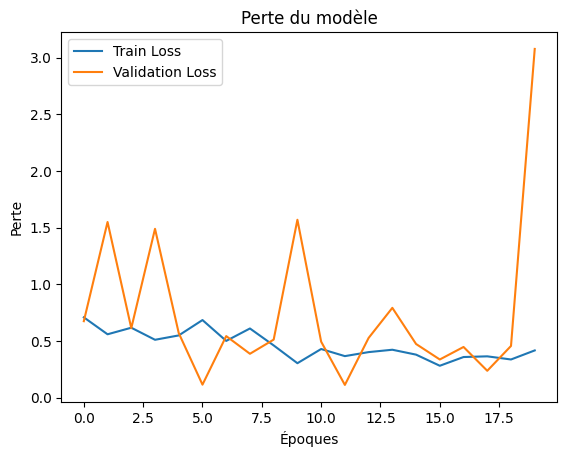

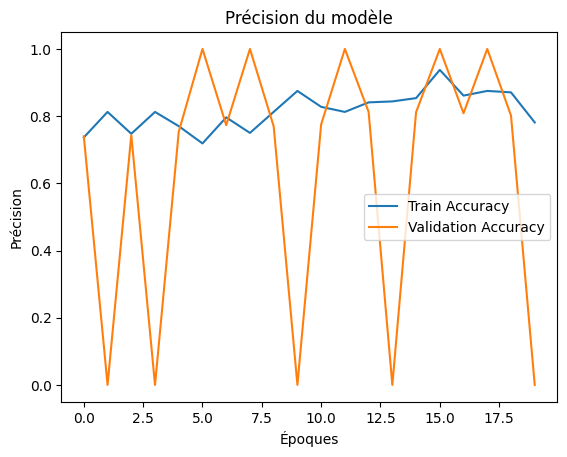

In [24]:
# Tracer l'historique de la perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

# Tracer l'historique de la précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.show()

In [26]:
model.save('modelPreEntraine/model1_20epoch.keras')

### Étape 6 : Fine-Tuning du Modèle
Une fois que nous avons vérifié que le modèle converge bien, nous pouvons déverrouiller certaines couches du modèle de base (ResNet) pour les réentraîner avec un taux d’apprentissage plus faible.

In [27]:
# Déverrouiller quelques couches pour fine-tuning
base_model.trainable = True

# Recompiler le modèle avec un taux d'apprentissage plus bas
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

### Étape 7 : Sauvegarde du Modèle
Une fois satisfait des résultats, tu peux sauvegarder le modèle pour une utilisation ultérieure.

In [ ]:
# Reprendre l'entraînement avec fine-tuning
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10)  # Entraînement sur un plus petit nombre d'époques

In [ ]:
model.save('plant_disease_model.h5')

### Étape 8 : Test du Modèle sur de Nouvelles Images
Enfin, nous pouvons tester le modèle sur des images individuelles pour vérifier les prédictions.

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Charger une nouvelle image pour tester
img_path = 'path_to_new_image.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prédire la maladie de la plante
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {predicted_class}")